In [1]:
import Pkg; Pkg.activate("./")

  Activating project at `~/Documents/Research/MonitoringMetrology/BackAction.jl/notebooks`


# Monte Carlo Wavefunction Method

In [20]:
using Random, Statistics, Plots, LaTeXStrings, DifferentialEquations, LinearAlgebra, BackAction, Base.Threads

In [9]:
# System definition
T = reshape([1.0 + 0.0im], 1,1)
alphas = [3.3 + 0.0im]
sys = System(BackAction.rd_H, [BackAction.rd_L], T, alphas)

System(NLEVELS=2
NCHANNELS=1
H=ComplexF64[-0.65 + 0.0im 0.0 - 2.857883832488647im; 0.0 + 2.857883832488647im 0.65 + 0.0im]
Ls=Matrix{ComplexF64}[[3.3 + 0.0im 1.7320508075688772 + 0.0im; 0.0 + 0.0im 3.3 + 0.0im]]
J=ComplexF64[10.889999999999999 + 0.0im 5.715767664977294 + 0.0im; 5.715767664977294 + 0.0im 13.889999999999999 + 0.0im])
Heff=ComplexF64[-0.65 - 5.444999999999999im 0.0 - 5.715767664977294im; 0.0 + 0.0im 0.65 - 6.944999999999999im])

In [28]:
# Parameters definition and problem initialization
params = BackAction.rd_params
ntimes = 100
t_eval = collect(LinRange(0.0, params.tf, ntimes))
prob_sys = generate_trajectoryproblem(sys, params, t_eval; progbar=false)

ODEProblem with uType Vector{ComplexF64} and tType Float64. In-place: false
timespan: (0.0, 3.0)
u0: 2-element Vector{ComplexF64}:
 0.0 + 0.0im
 1.0 + 0.0im

In [29]:
ensemble_problem = EnsembleProblem(prob_sys, prob_func=prob_func)
@time begin
    sim = solve(ensemble_problem, Tsit5(), EnsembleThreads(), trajectories=params.ntraj);
end

  0.014877 seconds (185.75 k allocations: 17.254 MiB)


EnsembleSolution Solution of length 10 with uType:
ODESolution{ComplexF64, 2, Vector{Vector{ComplexF64}}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Vector{ComplexF64}}}, Nothing, ODEProblem{Vector{ComplexF64}, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, ODEFunction{false, SciMLBase.AutoSpecialize, BackAction.var"#f!#19"{System}, UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, System, Nothing, Nothing}, Base.Pairs{Symbol, ContinuousCallback{BackAction.var"#condition#20"{BackAction.LindbladJump{Vector{Matrix{ComplexF64}}, Matrix{ComplexF64}, MersenneTwister, Base.RefValue{Float64}, Vector{Float64}, Vector{ComplexF64}}}, BackAction.LindbladJump{Vector{Matrix{ComplexF64}}, Matrix{ComplexF64}, MersenneTwister, Base.RefValue{Float64}, Vector{Float64}, Vector{ComplexF64}}, BackAction.LindbladJump{Vector{Matrix{ComplexF64}}, Matrix{ComplexF64}, MersenneTwis

In [30]:
z_sample = Array{Float64}(undef, ntimes, params.ntraj)
@threads for n in 1:params.ntraj
    for t in 1:ntimes
        psi = sim[n](t_eval[t])
        z_sample[t, n] = real(dot(psi, BackAction.sigma_z, psi))/dot(psi, psi)
    end
end 

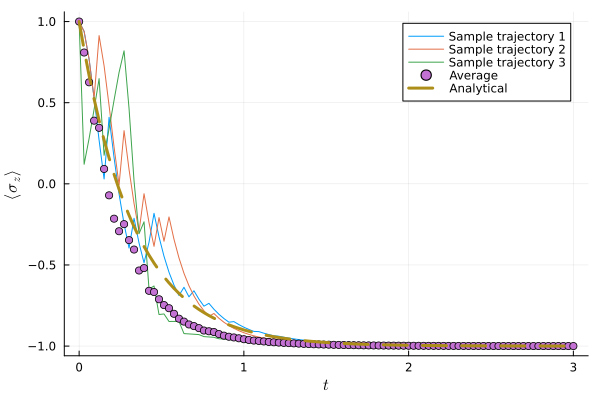

In [31]:
plot(t_eval, z_sample[:, 1], label="Sample trajectory 1", xlabel=L"t", ylabel=L"\langle\sigma_z\rangle")
plot!(t_eval, z_sample[:, 2], label="Sample trajectory 2")
plot!(t_eval, z_sample[:, 3], label="Sample trajectory 3")
scatter!(t_eval, dropdims(mean(z_sample, dims=2), dims=2), label="Average", linewidth=1)
plot!(t_eval, t -> 2*exp(-BackAction.rd_gamma*t) - 1, label="Analytical", linewidth=3, line=:dash)